### Final notebook
Unfortunately, due to difficulties later explained, this notebook crams 3 different tasks:
##### Data preparation
Now that we have split the data and done EDA, it's time to prepare the data for analysis. This might entail:
1. addressing missing values
2. trying to make numerical sense of non-numerical inputs (features)

##### Model Selection
###### Common models
1. Linear Regression
2. Decision Tree
3. Random Forest

###### Tactics
1. Cross validation
2. Grid Search of differet "hyperparamaters" (model settings)

   
##### Model Evaluation
1. Results expressed as RMSE
3. Results expressed as Confidence Interval
4. Layman's explanation

In [1]:
# splitting training data into 2 buckets (1 for inputs, 1 for price outputs) so they don't pollute each other during training
import os
import pandas #required to convert into a DataFrame

PROJECT_FILE_PATH = os.path.join("datasets", "housing")
csv_path = os.path.join(PROJECT_FILE_PATH, "stratified_training_80.csv")
full_stratified_training80_data = pandas.read_csv(csv_path)

training80_inputs_features_df  = full_stratified_training80_data.drop("median_house_value", axis=1)
training80_prices_labels_df = full_stratified_training80_data["median_house_value"].copy()

### Checking for blank values
I wanted a pulse check to see which dimensions are missing values and how bad is the relative damage. If the total_bedrooms had a lot of empty rows
and those empty rows were randomly distributed, it might make sense to remove the rows with empty data. However, if I had reason to believe the empties
showed up in a biased way (e.g. voters claiming to be undecided) AND the dimension wasn't a key feature of predicting prices, I might remove the entire
dimension. Given the percentages shown below and the book's hint, I feel more comfortable now auto-filling blanks with the median bedroom count.


In [2]:
missing_values_counts = training80_inputs_features_df.isnull().sum()
missing_values_percentages = (training80_inputs_features_df.isnull().sum() / len(training80_inputs_features_df)) * 100

# make a spreadsheet through pandas dataframe
missing_values_report = pandas.DataFrame({
    'Missing Values': missing_values_counts,
    'Percentage (%)': missing_values_percentages
})

print(missing_values_report)

                       Missing Values  Percentage (%)
longitude                           0         0.00000
latitude                            0         0.00000
housing_median_age                  0         0.00000
total_rooms                         0         0.00000
total_bedrooms                    158         0.95688
population                          0         0.00000
households                          0         0.00000
median_income                       0         0.00000
ocean_proximity                     0         0.00000
concatenated_position               0         0.00000
position_hash                       0         0.00000


In [3]:
from sklearn.impute import SimpleImputer # so I don't have to fill-in blanks one dimension at a time manually
imputer_tool = SimpleImputer(strategy="median")

# Cloning the training DataFrame, excluding the non-numerical dimensions "ocean_proximity" and "concatenated_position"
numerical_only_training80_df = training80_inputs_features_df.drop(["ocean_proximity", "concatenated_position", "position_hash"], axis=1)

imputer_tool.fit(numerical_only_training80_df)
imputed_numerical_only_training80_df = imputer_tool.transform(numerical_only_training80_df)
imputed_numerical_only_training80_df = pandas.DataFrame(imputed_numerical_only_training80_df, columns=numerical_only_training80_df.columns)

no_missing_values_verification = imputed_numerical_only_training80_df.isnull().sum()
#print(no_missing_values_verification) #proves that blank rows are replaced, now move on to encoding non-numerical (OCEAN_PROXIMITY)

### Dealing with non-numerical data
This is one-hot encoding, which converts different attributes into boolean values so we can start quantifying relationships.

In [4]:
from sklearn.preprocessing import OneHotEncoder

# Although there were multiple non-numeric dimensions, 2 of them are trashed b/c they were for ordering/selection.
ocean_proximity_df = training80_inputs_features_df[["ocean_proximity"]] #no need for unique identifier, because row ordering is preserved between DFs

encoder_tool_instance = OneHotEncoder()

ocean_proximity_encoded = encoder_tool_instance.fit_transform(ocean_proximity_df)

# Add details to new columns' names
ocean_proximity_encoded_df = pandas.DataFrame(ocean_proximity_encoded.toarray(), columns=encoder_tool_instance.get_feature_names_out(["ocean_proximity"]))

#print(ocean_proximity_encoded_df.head())

In [5]:
# Re-combine newly filled numerical data with newly one-hot encoded ocean_proximity data
final_training80_df = pandas.concat([imputed_numerical_only_training80_df, ocean_proximity_encoded_df], axis=1)
#final_training80_df.head() #proof 5 new columns replaced single column on ocean proximity

In [6]:
#An estimator leverages existing data to make predictions, and sci-kit has premade estimators
from sklearn.base import BaseEstimator # this is the template for making fresh estimators, which might include estimator type (regressors) or classes
from sklearn.base import TransformerMixin # a blueprint for making a new transformer that will learn from data and then modify info
import numpy

rooms_index = 3 #yes, I'm aware I could have done this in one single line like the textbook
bedrooms_index = 4
population_index = 5
households_index = 6

# Define the custom transformer class
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # Initialize with a hyperparameter
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # This transformer doesn't need to learn anything from the data, so we just return self

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_index] / X[:, households_index]
        population_per_household = X[:, population_index] / X[:, households_index]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_index] / X[:, rooms_index]
            return numpy.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return numpy.c_[X, rooms_per_household, population_per_household]

#At the end of the EDA notebook, we discovered that bedrooms:total rooms ratio offered moderately predictive (inverse) value for finding house prices 
#For this reason, I am overriding the suggestion in the textbook to disable "add_bedrooms_per_room"
#attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

# Apply the transformer to the data (assuming `housing.values` is your data)
housing_with_extra_attribs = CombinedAttributesAdder().transform(final_training80_df.values) #see how we used the whole transformer and its defaults?

# Optionally, convert the result back to a DataFrame for easier handling
housing_extra_attribs_df = pandas.DataFrame(housing_with_extra_attribs, columns=list(final_training80_df.columns) + ["rooms_per_household", "population_per_household","bedrooms_per_rooms"])
#print(housing_extra_attribs_df.head())

### Feature scaling
Some models will be thrown off if dimensions use different scales, like room count going up to the thousands but income bands only hitting 15
The solution is "feature scaling". We can min-max (use bottom and top of seen values, then adjust to 0-1), or standardization (find average + std dev)

Standardization is supposed to be the default go-to method because most models assume certain math,
but there are exceptions depending on data and model choice. In the real world, I'd check.
In the interest of expediency, I'm gonna take the author's hints on faith and just assume Standardization works.

I'll use SciKit's "StandardScaler" tool to help me eventually, but it will sit as the 3rd transformer in a 3-transformer pipeline

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# Need to dictate column headings or it will see 11, but expect 8 dimensions
original_columns = list(numerical_only_training80_df.columns)
added_columns = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
all_columns = original_columns + added_columns

housing_num_tr = num_pipeline.fit_transform(numerical_only_training80_df)

# Need to convert to Pandas dataframe b/c previous variable is a Numpy array
housing_num_tr_df = pandas.DataFrame(housing_num_tr, columns=all_columns)
print(housing_num_tr_df.describe()) #all means should be close to zero and all std devs should be close to 1

          longitude      latitude  housing_median_age   total_rooms  \
count  1.651200e+04  1.651200e+04        1.651200e+04  1.651200e+04   
mean  -5.249246e-15  2.811597e-16        8.778508e-17 -1.549148e-17   
std    1.000030e+00  1.000030e+00        1.000030e+00  1.000030e+00   
min   -2.385075e+00 -1.449702e+00       -2.199176e+00 -1.223624e+00   
25%   -1.111200e+00 -7.948529e-01       -8.472270e-01 -5.516115e-01   
50%    5.323472e-01 -6.451732e-01        2.756357e-02 -2.354803e-01   
75%    7.821265e-01  9.732389e-01        6.637749e-01  2.424578e-01   
max    2.630493e+00  2.951818e+00        1.856671e+00  1.716156e+01   

       total_bedrooms    population    households  median_income  \
count    1.651200e+04  1.651200e+04  1.651200e+04   1.651200e+04   
mean    -1.358732e-16  6.454785e-19 -1.054282e-17   1.148414e-16   
std      1.000030e+00  1.000030e+00  1.000030e+00   1.000030e+00   
min     -1.294906e+00 -1.269855e+00 -1.317625e+00  -1.772289e+00   
25%     -5.792186e-0

In [8]:
from sklearn.compose import ColumnTransformer

num_attribs = list(numerical_only_training80_df)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

'''
# special section on saving pipeline for use in other notebooks (e.g. 5)
full_pipeline.fit(final_training80_df) # need to denote final_training80_df or it won't carry over to Notebook 5 via JobLib
full_pipeline_from_notebook4 = full_pipeline # intentionally saving the pipeline with the verbose alias
import joblib #it was either this or Pickle
pipeline_path = os.path.join(PROJECT_FILE_PATH, "full_pipeline_from_notebook4.pkl")
joblib.dump(full_pipeline_from_notebook4, pipeline_path)
# special section ends
'''

housing_prepared = full_pipeline.fit_transform(full_stratified_training80_data)

new_num_attribs = num_attribs + ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
full_attribs = new_num_attribs + list(full_pipeline.named_transformers_['cat'].get_feature_names_out(cat_attribs))

housing_prepared_df = pandas.DataFrame(housing_prepared, columns=full_attribs)
#print(housing_prepared_df.describe())

# Select and Train Model

In [9]:
#Looking back, I want to save prepared data to a CSV so I can dedicate a new notebook to training the 3 moddels
#disregard the cells below as they are being kept as a backup until I'm 100% sure that the next notebook is self-sufficient

prepared_features_csv_path = os.path.join(PROJECT_FILE_PATH, "prepared_training80_features_only.csv")
separated_labels_csv_path = os.path.join(PROJECT_FILE_PATH, "prepared_training80_labels_only.csv")

housing_prepared_df.to_csv(prepared_features_csv_path, index=False)
print(f"Prepared training80 FEATURES saved to {prepared_features_csv_path}")

training80_prices_labels_df.to_csv(separated_labels_csv_path, index=False)
print(f"Prepared training80 LABELS saved to {separated_labels_csv_path}")

Prepared training80 FEATURES saved to datasets\housing\prepared_training80_features_only.csv
Prepared training80 LABELS saved to datasets\housing\prepared_training80_labels_only.csv


### Trying Method 1 of 3: Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() #take note of name as we will reuse this instance later
lin_reg.fit(housing_prepared, training80_prices_labels_df)

LinearRegression()

since this is a linear regression, think of it as:

    Price = a×A + b×B + c×C + Intercept

where:

1. lowercase a, b, c and INTERCEPT are the discovered/calculated coefficients
2. uppercase A B and C are the inputs coming from features such as household income or bedrooms per room

Linear Regression is favored when data is clean and the relationship between inputs and outputs is likely straightforward

In [11]:
some_data = full_stratified_training80_data.iloc[:3]
some_labels = training80_prices_labels_df.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared)) # predicted housing prices for the first 5 rows of data, so want to dive into the math

Predictions: [ 85657.90192014 305492.60737488 152056.46122456]


In [12]:
print("Labels:", list(some_labels)) # as a basis for comparison, these are the first 5 ACTUAL prices and 3/5 are close

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [13]:
coefficients = lin_reg.coef_
intercept = lin_reg.intercept_

first_row_values = some_data_prepared[0]

calculated_price = numpy.dot(coefficients, first_row_values) + intercept

print(f"Intercept: {intercept}")
for feature, value, coef in zip(full_attribs, first_row_values, coefficients):
    print(f"{feature}: Value = {value}, Coefficient = {coef}, Contribution = {value * coef}")
print(f"\nCalculated Price: {calculated_price}") # underlying math for prediction of 85K vs actual of 72K
print(f"Model Prediction: {lin_reg.predict([first_row_values])[0]}")

Intercept: 236926.06189652698
longitude: Value = -0.9413504586000941, Coefficient = -55649.63398452769, Contribution = 52385.80847226252
latitude: Value = 1.347438216815126, Coefficient = -56711.597428916226, Contribution = -76415.37371235616
housing_median_age: Value = 0.02756357138483158, Coefficient = 13734.720841922466, Contribution = 378.57795837706396
total_rooms: Value = 0.5847774454783182, Coefficient = -1943.0558635496077, Contribution = -1136.2552443082072
total_bedrooms: Value = 0.6403712747566713, Coefficient = 7343.229797309003, Contribution = 4702.393426133939
population: Value = 0.7326023581928217, Coefficient = -45709.28253579062, Contribution = -33486.72817702217
households: Value = 0.556286018753369, Coefficient = 45453.262776622236, Contribution = 25285.01458935789
median_income: Value = -0.8936472017581817, Coefficient = 74714.15226132619, Contribution = -66768.09310006887
rooms_per_household: Value = 0.017395255354801475, Coefficient = 6604.583966284028, Contributi

In [14]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared) # this is specific to linear regression, might rename later
lin_mse = mean_squared_error(training80_prices_labels_df, housing_predictions)
lin_rmse = numpy.sqrt(lin_mse)
lin_rmse # a root mean square error of 68,000 is not impressive accuracy, especially if prices are range from 120K to 250K (basically 30%-50% off)

np.float64(68627.87390018745)

### Trying Method 2 of 3: Decision Tree
DecisionTree is kind of a like using a series of questions to drive a recommendation engine, with the computer figuring out
How much to weigh each question or what order to ask them in.
The more layers of questions, the more specific you can get but the higher the risk of overfitting


In [15]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared_df, training80_prices_labels_df)

DecisionTreeRegressor()

In [16]:

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared_df, training80_prices_labels_df)

housing_predictions = tree_reg.predict(housing_prepared_df)

tree_mse = mean_squared_error(training80_prices_labels_df, housing_predictions)
tree_rmse = numpy.sqrt(tree_mse)
tree_rmse # you are going to see a zero, which means either the model (and data) is flawless or (the more likely) that there's an overfitting issue

np.float64(0.0)

#### Cross validation (specific to DecisionTree)
Due to the overfitting witnessed above and hesitation to dip into the test data, let's split the training data and do cross-validation
To do this, the computer will chop the training data into 10 slices (a.k.a. folds) and run 10 experiments where each fold is essentially
acting as testing data for a model trained by the other 9 folds.

Therefore, we should see 10 scores after
If we are lucky we will finaly see a mean RMSE (mean) that is above zero so we know it's not an overfitting error,
still  under the 68K we saw in linear regression model

In [17]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared_df, training80_prices_labels_df,
scoring="neg_mean_squared_error", cv=10)
decisiontree_rmse_scores = numpy.sqrt(-scores)

def display_scores(scores):
    print("CROSS VALIDATION SCORES ---------")
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(decisiontree_rmse_scores)

CROSS VALIDATION SCORES ---------
Scores: [73570.10283256 71538.37214325 69179.13554299 69534.32051453
 69451.61994818 75828.00879091 70312.13791906 72260.42108849
 68028.66070153 71560.65998985]
Mean: 71126.3439471347
Standard deviation: 2216.113061492467


#### Cross validation (Going back to Linear Regression)

In [18]:
scores = cross_val_score(lin_reg, housing_prepared_df, training80_prices_labels_df,
scoring="neg_mean_squared_error", cv=10)
linearregression_rmse_scores = numpy.sqrt(-scores)

display_scores(linearregression_rmse_scores)
#FYI, textbook expected average RMSE of 69,052 so a score of $69,104 means we are $51 too high. This could be explained away by randomization during preprocessing

CROSS VALIDATION SCORES ---------
Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180666


### How to read this: Linear Regression more accurate than Decision Tree
Since the mean of DecisionTree's RSME is still higher than linear regression's, we prefer the linear regression model.
Now, let's try 3rd model: RandomForest

### Trying Method 3 of 3: Random Forest

A RandomForest, as the name suggests, is a collection of Decision Trees. This is more appropriate than Linear Regression when you have
a bunch of complex intertwined cause-and-effects, such as an individual's occupation, religion, education, location being used to predict
political registration. Obviously some areas are more more likely to be religious than others, and some jobs indicate a level of/lack of education.

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared_df, training80_prices_labels_df)

# Calculate the training RMSE
housing_predictions = forest_reg.predict(housing_prepared_df)  # Predict on training data
randomforest_training_mse = mean_squared_error(training80_prices_labels_df, housing_predictions)
randomforest_training_rmse = numpy.sqrt(randomforest_training_mse)
print("Training RMSE:", randomforest_training_rmse)  # Print the training RMSE

Training RMSE: 18612.01245117788


In [20]:
# compare it vs cross-validation below
scores = cross_val_score(forest_reg, housing_prepared_df, training80_prices_labels_df,
                         scoring="neg_mean_squared_error", cv=10)
randomforest_rmse_scores = numpy.sqrt(-scores)

'''The cross validation RMSE is worse (higher numbers), indicating that the model works better when it's already seen the data and struggles when
it's exposed to new data (point of cross validation).

So although the cross validation figures are lower for randomforest than with linear regression, we shouldn't take it too seriously
'''
display_scores(randomforest_rmse_scores)

CROSS VALIDATION SCORES ---------
Scores: [51131.89622916 49024.20405289 46790.70459457 51705.83567298
 47393.86297604 51899.90785471 52492.41718496 49742.58702043
 48434.26875819 54248.74605408]
Mean: 50286.443039800906
Standard deviation: 2276.086229905919


### Falsely concluding that Random Forest is best

Preliminary RMSE scores:

* Linear Regression: 68K
* Decision Tree: 71K
* Random Forest: 50K

The RSME is only 50K for Random Forest, which is the lowest. On that data point alone, one might believe Random Forest is best. However, consider that score from the training-data WITHOUT cross-validation is only 18K. __This suggests that the model is "overfitted" to the training data__.

### Prelim results with 3 methods tested
The preliminary training suggests that Linear Regression might be the best way to predict housing prices.
Wouldn't it be neat if we could test out models with different parameters such as:

* picking and ignoring x features
* drafting 2 vs 6 features
* using 2 vs 4 trees/levels in a Decision Tree

Up until now, we have done Data Engineering and Data Science, but not Machine Learning
Now, we will use ML to experiment with different permutations of hyperparameters, which are like settings, to find best configuration for the model

In [21]:
from sklearn.model_selection import GridSearchCV

# these are the different settings/parameters
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]

'''So why are we exploring RandomForest first if Linear Regression showed more promise?
I don't think it's not because the textbook author wanted to build suspense and save things for last.
Maybe we're supposed to test more complicated alternative models first to see if anything, configured the right way, could compete with the
model that's in the lead (Linear Regression)
'''

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared_df, training80_prices_labels_df) #this blue box will talk about what was tried w/o commentary on what was learned

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [22]:
# This command will tell us what the "best" configuration is, but it won't quantify for us what the (average) RSME is
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

### Random forest
The RandomForest worked best while looking at 6 features at most, and having 30 different trees in the forrest. Pretend that 30 authors wrote 30
different instruction manuals for constructing a Lego tower. Each tower would look different, and we'd vote on the best-looking tower to decide which
instruction manual was best. If we have too few, we're not precise enough in our evaluation. Too many, and we'd be
overfitting (too specific).

Counterintuitive, but it's dangerous to consider too many features because I'd be giving chances to weaker predictors a chance to dilute
the impact of the stronger predictors. It could create white noise that the model extracts false insights/patterns from (a.k.a. overfitting).

In [23]:
cross_validation_results = grid_search.cv_results_ #cv_results is a reserved term

for mean_score, params in zip(cross_validation_results["mean_test_score"], cross_validation_results["params"]):
    print(numpy.sqrt(-mean_score), params)

#only 1 result was under $50,000 RMSE, so the below data matches the outcome from cell above
#Texbook predicted 49,682 and I got 49,960 which suggests this is on the right track
# it shows the best configureation now showing 49,752 with 6 max features and 30 n_estimators

63097.58209946841 {'max_features': 2, 'n_estimators': 3}
55594.04758666261 {'max_features': 2, 'n_estimators': 10}
53016.387553579894 {'max_features': 2, 'n_estimators': 30}
60690.48763115607 {'max_features': 4, 'n_estimators': 3}
52529.95300273018 {'max_features': 4, 'n_estimators': 10}
50459.67230562213 {'max_features': 4, 'n_estimators': 30}
58662.40876424908 {'max_features': 6, 'n_estimators': 3}
52458.88408750184 {'max_features': 6, 'n_estimators': 10}
49686.03762098992 {'max_features': 6, 'n_estimators': 30}
58898.74165089662 {'max_features': 8, 'n_estimators': 3}
52371.5426925551 {'max_features': 8, 'n_estimators': 10}
50000.124989917604 {'max_features': 8, 'n_estimators': 30}
60859.01609139633 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54579.79651887255 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60488.675054646395 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52655.217927002086 {'bootstrap': False, 'max_features': 3, 'n_estimators':

## NEW MILESTONE: FIRST ML DEMO

I just used GridSearch this beginner exercise, but it worked because the complexity is limited. In the real world, there will be situations where
the optimal number of estimators or optimal feature count is on a very wide range. In those situations, I should use RandomizedSearchCV instead. The
author gave readers some training wheels because it's my first ML project

***BTW THE ABOVE CELL MARKS THE FIRST TIME I'VE ACTUALLY LEVERAGED MACHINE-LEARNING***

### Ensemble Methods (page 82)

Since there are 16 features, you should see 16 different scores. Next, we will sort features by value to see what we keep/toss before using test data.


In [30]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.96820444e-02, 7.21351937e-02, 4.18848241e-02, 1.82903469e-02,
       1.71800320e-02, 1.85465074e-02, 1.63337622e-02, 2.99140671e-01,
       6.79181042e-02, 1.09720261e-01, 7.95838493e-02, 1.49890585e-02,
       1.57219959e-01, 4.79541358e-05, 3.06671448e-03, 4.26071729e-03])

In [25]:
#time to evaluate those Feature Scores

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.2991406714756842), 'median_income'),
 (np.float64(0.1572199589666528), 'INLAND'),
 (np.float64(0.10972026105997605), 'pop_per_hhold'),
 (np.float64(0.07968204437430002), 'longitude'),
 (np.float64(0.07958384930621996), 'bedrooms_per_room'),
 (np.float64(0.07213519368525008), 'latitude'),
 (np.float64(0.0679181041595418), 'rooms_per_hhold'),
 (np.float64(0.041884824051069386), 'housing_median_age'),
 (np.float64(0.01854650740009823), 'population'),
 (np.float64(0.018290346856192206), 'total_rooms'),
 (np.float64(0.01718003204736145), 'total_bedrooms'),
 (np.float64(0.016333762208544482), 'households'),
 (np.float64(0.0149890585104625), '<1H OCEAN'),
 (np.float64(0.0042607172860830555), 'NEAR OCEAN'),
 (np.float64(0.0030667144767298404), 'NEAR BAY'),
 (np.float64(4.795413583406586e-05), 'ISLAND')]

### Snap reactions (page 81 of Geron's book)
As we saw in previous notebooks, median household income is the best predictor of housing prices. One might think that properties are more
expensive on islands due to media portrayals. The reality is that island status has nearly zero correlation (see its ranking at bottom) and therefore 
nearly zero causality of prices. Was not expecting that.

### What to do about it (page 83)
The book makes a suggestion about dropping the 4 weakest signals out of the 5 ocean proximity features i.e. the model might be simpler if we just consider whether a housing district is Inland or not. The argument here is that we are trading off a tiny bit of accuracy in order to simplify the model, which may reduce overfitting error.

### Actual strategy
In the interest of simplicity, I'm just going to 

### Proof of switch to training data
I just wanted to show a row count of 4,128 to confirm this is __TEST__ and not __TRAINING__ data

In [29]:
# Import the test dataset, which is missing numerical values and encoding on ocean proximity
test_csv_path = os.path.join(PROJECT_FILE_PATH, "stratified_testing_20.csv")

full_stratified_test_data = pandas.read_csv(test_csv_path)
full_stratified_test_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,position_hash
count,4128.000000,4128.000000,4128.000000,4128.000000,4079.000000,4128.000000,4128.000000,4128.000000,4128.000000,4.128000e+03
mean,-119.545981,35.602049,28.583818,2688.656250,549.721746,1448.634205,509.651163,3.849818,206257.795058,2.186406e+09
std,2.010400,2.127889,12.629796,2345.997876,454.528621,1197.164964,407.677609,1.879332,114176.653346,1.237697e+09
min,-124.180000,32.550000,1.000000,2.000000,1.000000,5.000000,1.000000,0.499900,14999.000000,1.151161e+06
25%,-121.780000,33.920000,18.000000,1474.000000,301.000000,805.750000,283.000000,2.542675,118900.000000,1.121281e+09
50%,-118.460000,34.220000,28.000000,2159.500000,442.000000,1172.500000,416.000000,3.513200,181300.000000,2.201757e+09
75%,-117.980000,37.690000,37.000000,3171.250000,653.000000,1754.250000,613.250000,4.739225,268850.000000,3.254058e+09
max,-114.560000,41.950000,52.000000,32627.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000,4.294403e+09


In [36]:
# Split the test data into features (X) and labels (y)
X_test = full_stratified_test_data.drop("median_house_value", axis=1)
y_test = full_stratified_test_data["median_house_value"].copy()

# Now preprocess the test data via the pipeline we built before
X_test_prepared = full_pipeline.transform(X_test)

In [37]:
# Use the preprocessed test data to make predictions
final_random_forest_model = grid_search.best_estimator_
final_predictions = final_random_forest_model.predict(X_test_prepared)

# Calculate RMSE
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = numpy.sqrt(final_mse)
print(f"FINAL RMSE: {final_rmse}")

FINAL RMSE: 47635.96916371558


G:\My Drive\Education\BootCamp\housing-price-ML\venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [33]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
numpy.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
    loc=squared_errors.mean(),
    scale=stats.sem(squared_errors)))

array([45739.42981156, 49459.83902972])

In [34]:
training80_prices_labels_df.describe()

count     16512.000000
mean     207005.322372
std      115701.297250
min       14999.000000
25%      119800.000000
50%      179500.000000
75%      263900.000000
max      500001.000000
Name: median_house_value, dtype: float64

### RSME
Final evaluation of test data shows an RSME of 47,636, which is is a pinch better than what the book found at 47,730

### Confidence Interval
It might be more informative to give a confidence band. Said another way, if the computer is declaring 48468:
95% of the time, truth is between 45,739 and 49,460. The wider the gap between the low vs. high, the less confident we are in the result

### Explanation
If you were to buy/sell a home in California, my best model could help you predict a market price but it would be off 48K on average. For a housing district of 180K (median home price shown above) that's still a 27% swing.

Bottomline, the data set allows you to see a trend but not a reliable price point to anchor onto.

### "A picture says a thousand words"

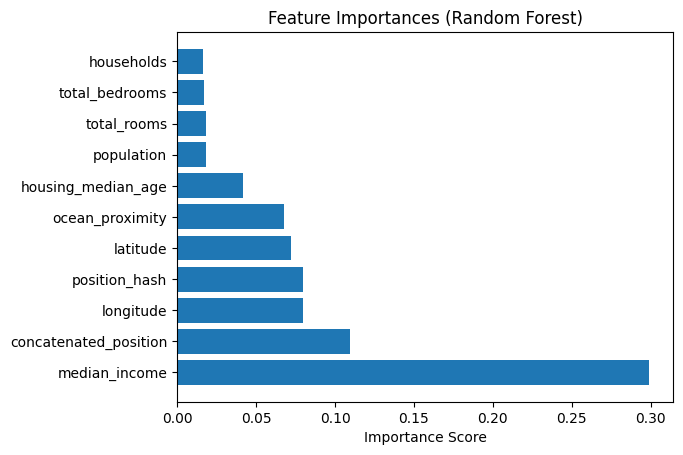

In [40]:
# Plot feature importances
importances = final_model.feature_importances_
attributes = full_stratified_training80_data.drop("median_house_value", axis=1).columns

sorted_importances = sorted(zip(importances, attributes), reverse=True)
importance_values, importance_labels = zip(*sorted_importances)

plt.barh(importance_labels, importance_values)
plt.xlabel("Importance Score")
plt.title("Feature Importances (Random Forest)")
plt.show()


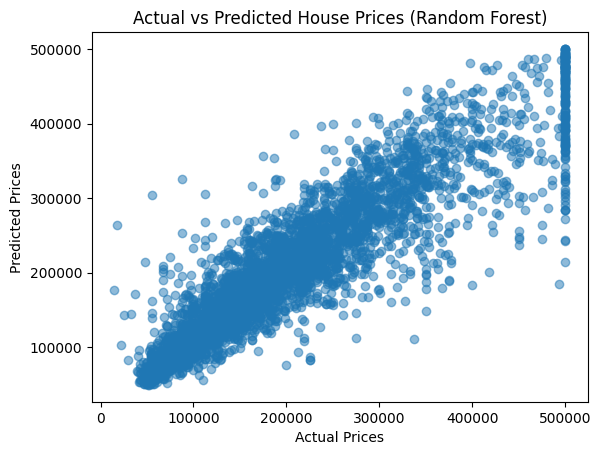

In [38]:
import matplotlib.pyplot as plt

# Create a scatter plot of actual vs. predicted house prices
plt.scatter(y_test, final_predictions, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices (Random Forest)")
plt.show()


### Improved visuals
The above blob clearly shows a linear trend which proves that the Random Forest model predicts prices with moderate accuracy and variance.

I have never heard of this before, but let's try a __hexbin__ below

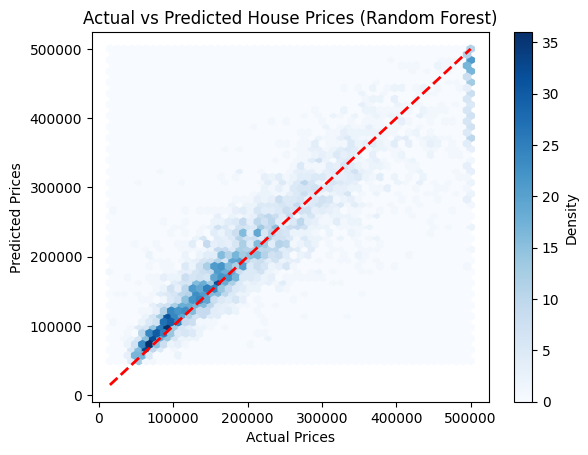

In [41]:
plt.hexbin(y_test, final_predictions, gridsize=50, cmap='Blues')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Add diagonal line
plt.colorbar(label='Density')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices (Random Forest)")
plt.show()


Great! Now, let's try to show a chart of the +/- variance, and we should expect swings be centered around the 50K or -50k marks

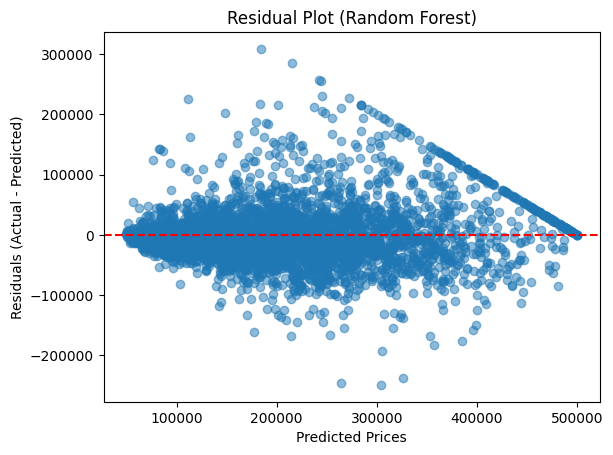

In [39]:
# Calculate residuals
residuals = y_test - final_predictions

# Create a scatter plot of residuals
plt.scatter(final_predictions, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Random Forest)")
plt.show()


## Conclusion
Thanks for reading my first ML project!